17


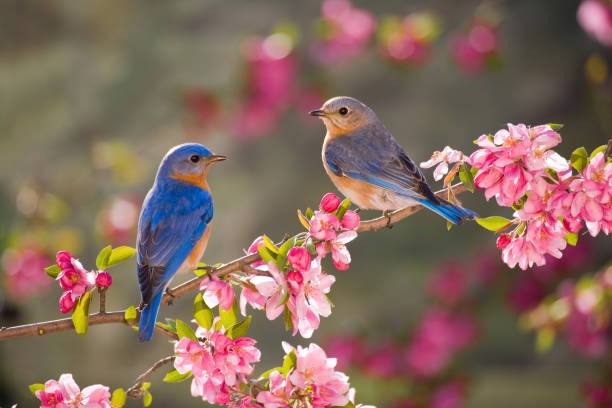

In [8]:
import glob, json, os
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

img_paths = glob.glob(r'D:\438161609\WPS云盘\BADOU\WEEK10\第10周：多模态大模型\data\*.jpeg')
img_paths.sort()
print(len(img_paths))
img_paths = img_paths[:len(img_paths)]
img_paths[:2]
Image.open(img_paths[0])

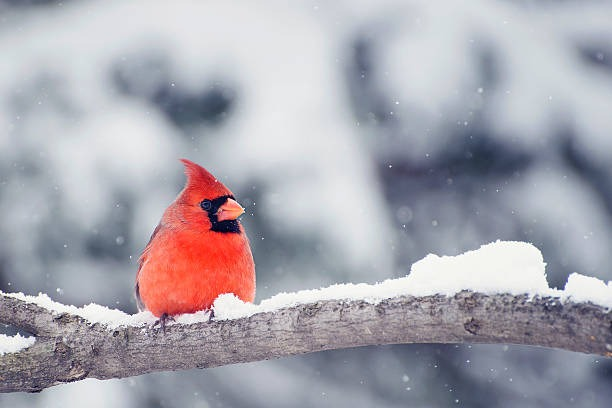

In [12]:
Image.open(img_paths[16])

通过大模型对图片进行描述

In [4]:
import os
from openai import OpenAI
import base64
from PIL import Image
# 将本地图片转换为base64编码
def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string
def image_to_discription_json(image_path):
# 使用base64编码的图片
    base64_image = image_to_base64(image_path)
    client = OpenAI(
        # 若没有配置环境变量，请用百炼API Key将下行替换为：api_key="sk-xxx",
        # api_key=os.getenv("DASHSCOPE_API_KEY")
        api_key='sk-67a5c9ec491c4832b45b0cbb567bc67f',
        base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    )
    completion = client.chat.completions.create(
        model="qwen-vl-plus",  # 此处以qwen-vl-plus为例，可按需更换模型名称。模型列表：https://help.aliyun.com/zh/model-studio/getting-started/models
        messages=[{"role": "user","content": [
                {"type": "image_url",
                 "image_url": {"url": f"data:image/png;base64,{base64_image}"}},
                {"type": "text", "text": "对图片给出一段简单的描述，字数不超过20个字"},
                ]}]
        )
    # print(completion.model_dump_json())
    return completion.choices[0].message.content
img_captions=[]
img_captions=[image_to_discription_json(x) for x in img_paths]

保存json文件

In [5]:
import json

# 假设 img_captions 已定义
# img_captions = {...}

# 保存到 JSON 文件
with open('img_captions.json', 'w', encoding='utf-8') as f:
    json.dump(img_captions, f, ensure_ascii=False, indent=4)


In [7]:
print(img_captions)

['两只蓝鸟栖息在开满粉花的枝头。', '一只棕色猫头鹰，拥有明亮的黄色眼睛，正凝视前方。', '一只长毛猫趴在地毯上，眼神温柔。', '一只金毛犬开心地坐在木地板上。', '一只金毛犬在室内地毯上开心地躺着。', '两只柯基犬正在地板上吃东西。', '一只黑棕相间的小狗在草地上奔跑。', '一只黑色小鸟栖息在树枝上，姿态优雅。', '长尾阔嘴鸟栖息于树枝，色彩斑斓。', '一只可爱的银色虎斑小猫正坐着凝视前方。', '绿鹊栖息于苔藓树枝，色彩斑斓。', '一只棕色斑文鸟栖息在细枝上，背景模糊。', '一只色彩斑斓的蜂鸟在空中飞翔。', '一人与两只狗在户外互动，气氛温馨。', '一只浅棕色小狗躺在床下休息。', '粉红色的火烈鸟特写，羽毛鲜艳，眼神锐利。', '红衣鸟栖息雪枝，冬日静谧一景。']


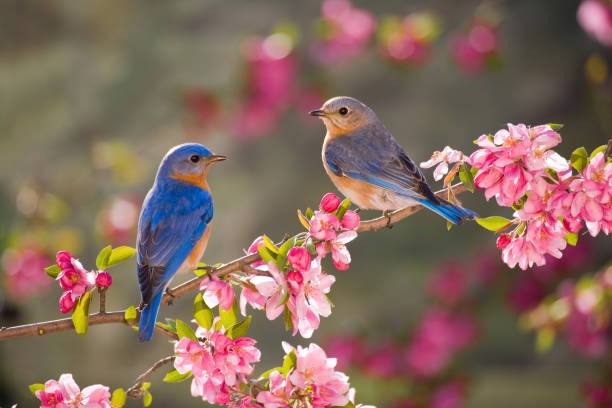

In [5]:
Image.open(img_paths[0])

In [6]:
import json
img_captions = json.load(open('img_captions.json', encoding='utf-8'))
img_captions[0]

'两只蓝鸟栖息在开满粉花的枝头。'

# 加载CLIP模型

In [7]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

model = ChineseCLIPModel.from_pretrained(r"D:\438161609\WPS云盘\BADOU\models\chinese-clip-vit-base-patch16") # 中文clip模型
processor = ChineseCLIPProcessor.from_pretrained(r"D:\438161609\WPS云盘\BADOU\models\chinese-clip-vit-base-patch16") # 预处理

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# 图像编码

In [9]:
img_image_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    #tqdm_notebook：这是一个进度条库，用于在Jupyter Notebook中显示循环的进度。
    imgs = [ Image.open(path) for path in img_paths[idx*batch_size: (idx+1)*batch_size] ]
    
    if len(imgs) == 0:
        break
    
    inputs = processor(images=imgs, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)

    break
        
img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

C:\Users\52564\AppData\Local\Temp\ipykernel_32764\2441136177.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
print(inputs)
     

{'input_ids': tensor([[ 101,  697, 1372, 5905, 7881, 3411, 2622, 1762, 2458, 4007, 5106, 5709,
         4638, 3363, 1928,  511,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [ 101,  671, 1372, 3473, 5682, 4344, 1928, 7916, 8024, 2881, 3300, 3209,
          778, 4638, 7942, 5682, 4706, 4714, 8024, 3633, 1125, 6228, 1184, 3175,
          511,  102],
        [ 101,  671, 1372, 7270, 3688, 4344, 6640, 1762, 1765, 3691,  677, 8024,
         4706, 4868, 3946, 3382,  511,  102,    0,    0,    0,    0,    0,    0,
            0,    0],
        [ 101,  671, 1372, 7032, 3688, 4305, 2458, 2552, 1765, 1777, 1762, 3312,
         1765, 3352,  677,  511,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [ 101,  671, 1372, 7032, 3688, 4305, 1762, 2147, 1079, 1765, 3691,  677,
         2458, 2552, 1765, 6720, 4708,  511,  102,    0,    0,    0,    0,    0,
            0,    0],
        [ 101,  697, 1372, 3392, 1825, 4305, 3633, 1762, 1765, 335

In [10]:
img_image_feat.shape # 20张图片 512 维度

(17, 512)

# 文本编码

In [11]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    texts = [ text for text in img_captions[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
    break
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

C:\Users\52564\AppData\Local\Temp\ipykernel_32764\232757992.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
img_texts_feat.shape

(17, 512)

# 尝试1：相似度计算

In [17]:
query_idx = 2

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T) # 矩阵计算
sim_idx = sim_result.argsort()[::-1][1:4]

输入文本:  一只长毛猫趴在地毯上，眼神温柔。


([], [])

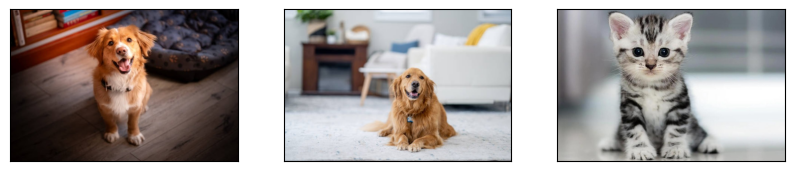

In [18]:
print('输入文本: ', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

In [19]:
query_idx = 3

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

文本识别结果:  ['一只金毛犬在室内地毯上开心地躺着。', '一只浅棕色小狗躺在床下休息。', '一只长毛猫趴在地毯上，眼神温柔。']


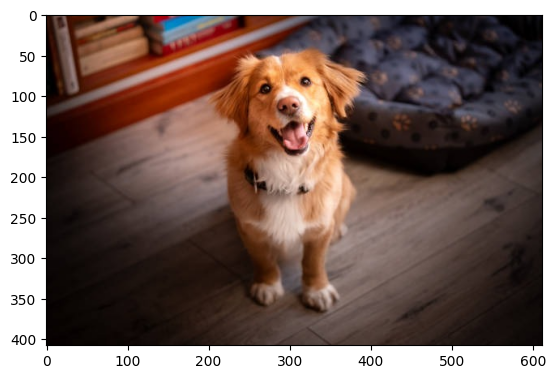

In [20]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions[x] for x in sim_idx])

# 文本标签编码

In [29]:
import jieba

In [30]:
jieba.lcut('今天天气很好，心情也很好。')

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\52564\AppData\Local\Temp\jieba.cache
Loading model cost 0.669 seconds.
Prefix dict has been built successfully.


['今天天气', '很', '好', '，', '心情', '也', '很', '好', '。']

In [31]:
jieba.lcut(img_captions[0])

['两只', '蓝鸟', '栖息', '在', '开满', '粉花', '的', '枝头', '。']

In [32]:
img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])

In [40]:
img_captions2words[:50]

['姿态',
 '一景',
 '静谧',
 '明亮',
 '长毛',
 '木地板',
 '优雅',
 '色彩斑斓',
 '东西',
 '一只',
 '银色',
 '小猫',
 '正坐',
 '蜂鸟',
 '户外',
 '开心',
 '柯基犬',
 '长尾',
 '绿鹊',
 '火烈鸟',
 '枝头',
 '棕色',
 '一人',
 '锐利',
 '树枝',
 '模糊',
 '奔跑',
 '拥有',
 '金毛犬',
 '坐在',
 '黑色',
 '特写',
 '温馨',
 '背景',
 '地板',
 '互动',
 '羽毛',
 '休息',
 '室内',
 '小鸟',
 '眼睛',
 '可爱',
 '浅棕色',
 '细枝',
 '黄色',
 '红衣',
 '雪枝',
 '栖息',
 '两只',
 '文鸟']

In [42]:
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))

In [43]:
img_captions2words[:20]

['姿态',
 '一景',
 '静谧',
 '明亮',
 '长毛',
 '木地板',
 '优雅',
 '色彩斑斓',
 '东西',
 '一只',
 '银色',
 '小猫',
 '正坐',
 '蜂鸟',
 '户外',
 '开心',
 '柯基犬',
 '长尾',
 '绿鹊',
 '火烈鸟']

In [36]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

C:\Users\52564\AppData\Local\Temp\ipykernel_32764\1150539393.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):


  0%|          | 0/4 [00:00<?, ?it/s]

# 尝试2：标签相似度计算

In [1]:
query_idx = 8

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:7]

NameError: name 'np' is not defined

文本识别结果:  ['文鸟', '小鸟', '栖息', '长尾', '一只', '坐在']


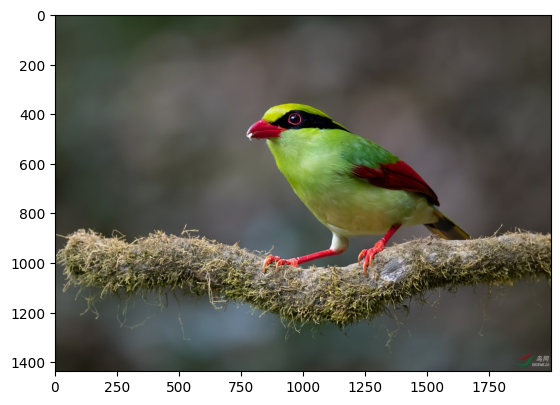

In [39]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])